# 基于PaddleDetection的情绪识别

## 一、项目背景


------------------------

**表情识别**(facialexpression recognition, FER)是计算机理解人类情感的一个重要方向，也是人机交互的一个重要方面。表情识别是指从静态照片或视频序列中选择出表情状态，从而确定对人物的情绪与心理变化。20世纪70年代的美国心理学家Ekman和Friesen通过大量实验，定义了人类六种基本表情：快乐，气愤，惊讶，害怕，厌恶和悲伤，除此之外后续的分类任务大多增添了一个中性表情。人脸表情识别（FER）在人机交互和情感计算中有着广泛的研究前景，包括人机交互、情绪分析、智能安全等。

**PaddleDetection**为基于飞桨PaddlePaddle的端到端目标检测套件，内置30+模型算法及250+预训练模型，覆盖目标检测、实例分割、跟踪、关键点检测等方向，其中包括服务器端和移动端高精度、轻量级产业级SOTA模型、冠军方案和学术前沿算法，并提供配置化的网络模块组件、十余种数据增强策略和损失函数等高阶优化支持和多种部署方案，在打通数据处理、模型开发、训练、压缩、部署全流程的基础上，提供丰富的案例及教程，加速算法产业落地应用。

**效果如下图所示：**
<center><img src="https://ai-studio-static-online.cdn.bcebos.com/cb9c51b012d74a3a89e9a9f7acf32ca6db87bcec5a7f4703889483904f8d72ed"></center>


*本项目利用飞桨框架搭建VGG网络，可优化后改使用ResNet34网络,基于fer2013数据集实现情绪分析*


主要技术点有：
* 使用PaddleDetection提供的目标检测模型，将人物信息提取出来。 
* 训练人脸检测模型，对提取出的人物信息进行人脸检测，判断能否进行情绪识别。 
* 将识别出来的可以进行情绪识别的人脸输入进VGG分类模型，通过分析表情和背景识别出人物情绪。
* 最后将识别出来的表情结合PaddleDetection标注在图片人脸上。


## 二、环境和数据集的准备

--------

**表情识别的整体流程如下：**

![](https://ai-studio-static-online.cdn.bcebos.com/53731ed2180c48508eb890208aac5f35f30a9138cd434cc3b40fcd27b76c8552)


### 2.1 数据集介绍

本次实验的使用的数据集为Fer2013，它于2013年国际机器学习会议（ICML）上推出，并成为比较表情识别模型性能的基准之一，同时也作为了2013年Kaggle人脸识别比赛的数据。Fer2013包含28709张训练集图像、3589张公开测试集图像和3589张私有测试集图像，每张图像为4848大小的灰度图片，如下图所示。Fer2013数据集中由有生气(angry)、厌恶(disgust)、恐惧(fear)、开心(happy)、难过(sad)、惊讶(surprise)和中性(neutral)七个类别组成。由于这个数据集大多是通过爬虫在互联网上进行爬取所得，因此存在一定的误差性。

![](https://ai-studio-static-online.cdn.bcebos.com/7372be26a2a94844a8cdb722b661d223a647ea87178644ee8f817e26f8bf8967)

### 2.2 数据集准备

将数据集的压缩包解压到emotic文件夹中：

In [ ]:
%cd /home/aistudio
!unzip -oq data/data150109/archive.zip -d ./emotic

/home/aistudio


将数据集整理成以文件名表示类别的形式

In [ ]:
import os
import cv2
import tqdm

def make_new_dir(root_dir, tag, save_dir):
    img_root = os.path.join(root_dir, tag)
    img_dir_list = os.listdir(img_root)
    if not os.path.isdir(save_dir):
        os.mkdir(save_dir)
    print(img_dir_list)
    for img_dir in tqdm.tqdm(img_dir_list):
        img_folder = os.path.join(img_root, img_dir)
        img_list = [f for f in os.listdir(img_folder) if f.endswith('.jpg')]
        name_first = img_dir[:2].upper()
        for index, filename in enumerate(img_list):
            img = cv2.imread(os.path.join(img_folder, filename), -1)
            save_name = name_first+"{0:0>5}.jpg".format(index)
            cv2.imwrite(os.path.join(save_dir, save_name), img)

In [ ]:
root_dir = r"emotic"
save_dir = r"train"
make_new_dir(root_dir, "train", save_dir) # 制作训练集

  0%|          | 0/7 [00:00<?, ?it/s]

['surprise', 'neutral', 'angry', 'disgust', 'sad', 'happy', 'fear']


100%|██████████| 7/7 [00:03<00:00,  2.20it/s]


In [ ]:
root_dir = r"emotic"
save_dir = r"test"
make_new_dir(root_dir, "test", save_dir) # 制作测试集

 14%|█▍        | 1/7 [00:00<00:00,  8.26it/s]

['surprise', 'neutral', 'angry', 'disgust', 'sad', 'happy', 'fear']


 29%|██▊       | 2/7 [00:00<00:00,  7.93it/s]100%|██████████| 7/7 [00:00<00:00,  8.47it/s]


In [ ]:
# 随机移动10%数量的图像到val文件夹中
import shutil
import os
import random

def move2newDir(inputFolder, saveFolder):
    filenames = [f for f in os.listdir(inputFolder) if f.endswith('.jpg')]
    random.shuffle(filenames)
    num_val = int(0.1*len(filenames))
    if not os.path.isdir(saveFolder):
        os.mkdir(saveFolder)
        
    for index, filename in enumerate(filenames):  
        src = os.path.join(inputFolder,filename)
        dst = os.path.join(saveFolder,filename)       
        shutil.move(src, dst)
        if index == num_val:
            break

In [ ]:
inputFolder = r"train"
saveFolder = r"val"
move2newDir(inputFolder, saveFolder)

### 2.3 查看数据集
查看数据集图片：train/val/test文件夹里包含7种表情类型图片 以NE,HA,SU作为名称前缀的图片分别代表neutral，happy，surprised三种表情

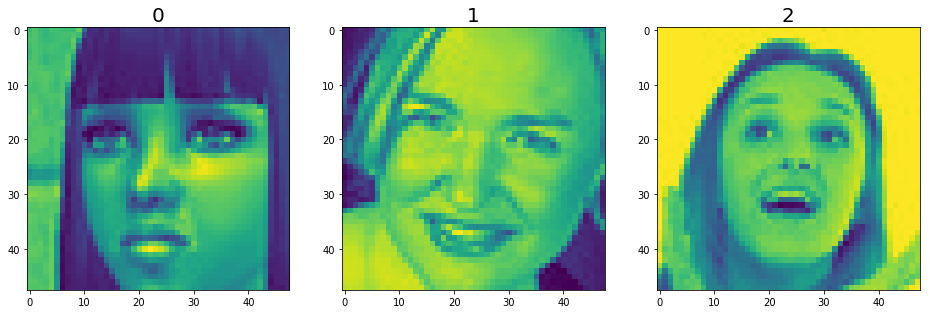

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image

#选取 test文件夹 作为图片路径
DATADIR = 'test' 

# 文件名以N开头的是普通表情的图片，以H开头的是高兴图片，以S开头的是惊讶的图片

#file0-3选取了三个文件夹里的三个表情

file0 = 'NE00127.jpg'
file1 = 'HA00453.jpg'
file2 = 'SU00224.jpg'

# 读取图片
img0 = Image.open(os.path.join(DATADIR, file0))
img0 = np.array(img0)
img1 = Image.open(os.path.join(DATADIR, file1))
img1 = np.array(img1)
img2 = Image.open(os.path.join(DATADIR, file2))
img2 = np.array(img2)

# 画出读取的图片
plt.figure(figsize=(16, 8))

f = plt.subplot(131)
f.set_title('0', fontsize=20)
plt.imshow(img0)

f = plt.subplot(132)
f.set_title('1', fontsize=20)
plt.imshow(img1)

f = plt.subplot(133)
f.set_title('2', fontsize=20)
plt.imshow(img2)
#plt展示出三个表情
plt.show()

## 三、数据预处理

--------------------

### 3.1 定义数据读取器
使用OpenCV从磁盘读入图片，将每张图缩放到224×224大小，并且将像素值调整到[−1,1][-1, 1][−1,1]之间，代码如下所示：

In [ ]:
import cv2
import random
import numpy as np
import os

# 对读入的图像数据进行预处理
def transform_img(img):
    # 将图片尺寸缩放道 224x224
    img = cv2.resize(img, (224, 224))
    # 读入的图像数据格式是[H, W, C]
    # 使用转置操作将其变成[C, H, W]
    img = np.transpose(img, (2,0,1))
    img = img.astype('float32')
    # 将数据范围调整到[-1.0, 1.0]之间
    img = img / 255.
    img = img * 2.0 - 1.0
    return img

# 定义训练集数据读取器
def data_loader(datadir, batch_size=20, mode = 'train'):
    # 将datadir目录下的文件列出来，每条文件都要读入
    filenames = os.listdir(datadir)
    def reader():
        if mode == 'train':
            # 训练时随机打乱数据顺序
            random.shuffle(filenames)
        batch_imgs = []
        batch_labels = []
        for name in filenames:
            filepath = os.path.join(datadir, name)
            img = cv2.imread(filepath)
            img = transform_img(img)
            #依次读取每张图片的名称首字母用于标记标签
            # 7类表情 'sad', 'disgust', 'happy', 'fear', 'surprise', 'neutral', 'angry'
            # SA开头表示sad表情用0标签 
            # DI开头表示disgust表情用1标签 
            # HA开头表示happy表情用2标签，以此类推
            if name[:2] == 'SA':
                label = 0 
            elif name[:2] == 'DI':
                label = 1
            elif name[:2] == 'HA':
                label = 2
            elif name[:2] == 'FE':
                label = 3 
            elif name[:2] == 'SU':
                label = 4
            elif name[:2] == 'NE':
                label = 5
            elif name[:2] == 'AN':
                label = 6
            else:
                raise('Not excepted file name')
            # 每读取一个样本的数据，就将其放入数据列表中
            batch_imgs.append(img)
            batch_labels.append(label)
            if len(batch_imgs) == batch_size:
                # 当数据列表的长度等于batch_size的时候，
                # 把这些数据当作一个mini-batch，并作为数据生成器的一个输出
                imgs_array = np.array(batch_imgs).astype('float32')
                labels_array = np.array(batch_labels).reshape(-1, 1)
                yield imgs_array, labels_array
                batch_imgs = []
                batch_labels = []

        if len(batch_imgs) > 0:
            # 剩余样本数目不足一个batch_size的数据，一起打包成一个mini-batch
            imgs_array = np.array(batch_imgs).astype('float32')
            labels_array = np.array(batch_labels).reshape(-1, 1)
            yield imgs_array, labels_array

    return reader

# 定义验证集数据读取器
def valid_data_loader(datadir, batch_size=20, mode='valid'):
    filenames = os.listdir(datadir)
    def reader():
        batch_imgs = []
        batch_labels = []
            # 根据图片文件名加载图片，并对图像数据作预处理
        for name in filenames:
            filepath = os.path.join(datadir, name)
            # 每读取一个样本的数据，就将其放入数据列表中
            img = cv2.imread(filepath)
            img = transform_img(img)
            #根据名称判断标签
            if name[:2] == 'SA':
                label = 0 
            elif name[:2] == 'DI':
                label = 1
            elif name[:2] == 'HA':
                label = 2
            elif name[:2] == 'FE':
                label = 3 
            elif name[:2] == 'SU':
                label = 4
            elif name[:2] == 'NE':
                label = 5
            elif name[:2] == 'AN':
                label = 6
            else:
                raise('Not excepted file name')
            # 每读取一个样本的数据，就将其放入数据列表中
            batch_imgs.append(img)
            batch_labels.append(label)
            if len(batch_imgs) == batch_size:
                # 当数据列表的长度等于batch_size的时候，
                # 把这些数据当作一个mini-batch，并作为数据生成器的一个输出
                imgs_array = np.array(batch_imgs).astype('float32')
                labels_array = np.array(batch_labels).reshape(-1, 1)
                yield imgs_array, labels_array
                batch_imgs = []
                batch_labels = []

        if len(batch_imgs) > 0:
            # 剩余样本数目不足一个batch_size的数据，一起打包成一个mini-batch
            imgs_array = np.array(batch_imgs).astype('float32')
            labels_array = np.array(batch_labels).reshape(-1, 1)
            yield imgs_array, labels_array

    return reader

### 3.2 校验数据
将train文件夹中的数据传入到数据读取器，再输出处理后的数据格式

In [ ]:
# 查看数据形状
DATADIR = 'train'
train_loader = data_loader(DATADIR,batch_size=20, mode='train')
data_reader = train_loader()
data = next(data_reader) #返回迭代器的下一个项目给data
# 输出表示： 图像数据（batchsize，通道数，224*224）标签（batchsize，标签维度）
print("train mode's shape:")
print("data[0].shape = %s, data[1].shape = %s" %(data[0].shape, data[1].shape))

eval_loader = data_loader(DATADIR,batch_size=20, mode='eval')
data_reader = eval_loader()
data = next(data_reader)
# 输出表示： 图像数据（batchsize，通道数，224*224）标签（batchsize，标签维度）
print("eval mode's shape:")
print("data[0].shape = %s, data[1].shape = %s" %(data[0].shape, data[1].shape))

train mode's shape:
data[0].shape = (20, 3, 224, 224), data[1].shape = (20, 1)
eval mode's shape:
data[0].shape = (20, 3, 224, 224), data[1].shape = (20, 1)


## 四、VGG模型实现

---------------

### 4.1 VGG模型介绍

本案例中我们使用VGG网络进行表情识别，首先我们来了解一下VGG模型。 VGG是当前最流行的CNN模型之一，2014年由Simonyan和Zisserman发表在ICLR 2015会议上的论文《Very Deep Convolutional Networks For Large-scale Image Recognition》提出，其命名来源于论文作者所在的实验室Visual Geometry Group。VGG设计了一种大小为3x3的小尺寸卷积核和池化层组成的基础模块，通过堆叠上述基础模块构造出深度卷积神经网络，该网络在图像分类领域取得了不错的效果，在大型分类数据集ILSVRC上，VGG模型仅有6.8% 的top-5 test error 。VGG模型一经推出就很受研究者们的欢迎，因为其网络结构的设计合理，总体结构简明，且可以适用于多个领域。VGG的设计为后续研究者设计模型结构提供了思路。

下图是VGG-16的网络结构示意图，一共包含13层卷积和3层全连接层。VGG网络使用3×3的卷积层和池化层组成的基础模块来提取特征，三层全连接层放在网络的最后组成分类器，最后一层全连接层的输出即为分类的预测。 在VGG中每层卷积将使用ReLU作为激活函数，在全连接层之后添加dropout来抑制过拟合。使用小的卷积核能够有效地减少参数的个数，使得训练和测试变得更加有效。比如如果我们想要得到感受野为5的特征图，最直接的方法是使用5×5的卷积层，但是我们也可以使用两层3×3卷积层达到同样的效果，并且只需要更少的参数。另外由于卷积核比较小，我们可以堆叠更多的卷积层，提取到更多的图片信息，来提高图像分类的准确率。VGG模型的成功证明了增加网络的深度，可以更好的学习图像中的特征模式，达到更高的分类准确率。

<center><img src="https://ai-studio-static-online.cdn.bcebos.com/6393096988b44ad0be30427b3f0da229cd5ebe05186e4b01b3ecd35d5b0c28f3"></center>


### 4.2 代码实现

#### VGG网络的定义代码如下

In [ ]:
# -*- coding:utf-8 -*-
# VGG模型代码
import numpy as np
import paddle
# from paddle.nn import Conv2D, MaxPool2D, BatchNorm, Linear
from paddle.nn import Conv2D, MaxPool2D, BatchNorm2D, Linear

# 定义vgg网络
class VGG(paddle.nn.Layer):
    def __init__(self, num_class):
        super(VGG, self).__init__()

        in_channels = [3, 64, 128, 256, 512, 512]
        # 定义第一个卷积块，包含两个卷积 输入通道数是图片通道数即3 输出通道数即out_channels=in_channels[1]=64
        self.conv1_1 = Conv2D(in_channels=in_channels[0], out_channels=in_channels[1], kernel_size=3, padding=1, stride=1)
        self.conv1_2 = Conv2D(in_channels=in_channels[1], out_channels=in_channels[1], kernel_size=3, padding=1, stride=1)
        # 定义第二个卷积块，包含两个卷积 输入通道数是上一个卷积块的输出通道数即64 输出通道数即out_channels=in_channels[2]=128
        self.conv2_1 = Conv2D(in_channels=in_channels[1], out_channels=in_channels[2], kernel_size=3, padding=1, stride=1)
        self.conv2_2 = Conv2D(in_channels=in_channels[2], out_channels=in_channels[2], kernel_size=3, padding=1, stride=1)
        # 定义第三个卷积块，包含三个卷积 输入通道数是上一个卷积块的输出通道数即128 输出通道数即out_channels=in_channels[3]=256
        self.conv3_1 = Conv2D(in_channels=in_channels[2], out_channels=in_channels[3], kernel_size=3, padding=1, stride=1)
        self.conv3_2 = Conv2D(in_channels=in_channels[3], out_channels=in_channels[3], kernel_size=3, padding=1, stride=1)
        self.conv3_3 = Conv2D(in_channels=in_channels[3], out_channels=in_channels[3], kernel_size=3, padding=1, stride=1)
        # 定义第四个卷积块，包含三个卷积 输入通道数是上一个卷积块的输出通道数即256 输出通道数即out_channels=in_channels[4]=512
        self.conv4_1 = Conv2D(in_channels=in_channels[3], out_channels=in_channels[4], kernel_size=3, padding=1, stride=1)
        self.conv4_2 = Conv2D(in_channels=in_channels[4], out_channels=in_channels[4], kernel_size=3, padding=1, stride=1)
        self.conv4_3 = Conv2D(in_channels=in_channels[4], out_channels=in_channels[4], kernel_size=3, padding=1, stride=1)
        # 定义第五个卷积块，包含三个卷积 输入通道数是上一个卷积块的输出通道数即512 输出通道数即out_channels=in_channels[5]=512
        self.conv5_1 = Conv2D(in_channels=in_channels[4], out_channels=in_channels[5], kernel_size=3, padding=1, stride=1)
        self.conv5_2 = Conv2D(in_channels=in_channels[5], out_channels=in_channels[5], kernel_size=3, padding=1, stride=1)
        self.conv5_3 = Conv2D(in_channels=in_channels[5], out_channels=in_channels[5], kernel_size=3, padding=1, stride=1)

        # VGG网络的设计严格使用3*3的卷积层和池化层来提取特征，并在网络的最后面使用三层全连接层，将最后一层全连接层的输出作为分类的预测。
        # 使用Sequential 将全连接层和relu组成一个线性结构（fc + relu）
        # 当输入为224x224时，经过五个卷积块和池化层后，特征维度变为[512x7x7]
        self.fc1 = paddle.nn.Sequential(paddle.nn.Linear(512 * 7 * 7, 4096), paddle.nn.ReLU())

        self.drop1_ratio = 0.5
        self.dropout1 = paddle.nn.Dropout(self.drop1_ratio, mode='upscale_in_train')
        # 使用Sequential 将全连接层和relu组成一个线性结构（fc + relu）
        self.fc2 = paddle.nn.Sequential(paddle.nn.Linear(4096, 4096), paddle.nn.ReLU())

        self.drop2_ratio = 0.5
        self.dropout2 = paddle.nn.Dropout(self.drop2_ratio, mode='upscale_in_train')

        #全连接层的输出
        # paddle.nn.Linear(in_features, out_features, weight_attr=None, bias_attr=None, name=None)
        # out_features 由输出标签的个数决定 本案例识别的7种表情，对应了3种标签。 因此 out_features = 3
        self.fc3 = paddle.nn.Linear(4096, 1000)
        self.fc4 = paddle.nn.Linear(1000, num_class)

        self.relu = paddle.nn.ReLU()
        self.pool = MaxPool2D(stride=2, kernel_size=2)

    def forward(self, x):
        #激活函数用relu
        x = self.relu(self.conv1_1(x))
        x = self.relu(self.conv1_2(x))
        x = self.pool(x)

        x = self.relu(self.conv2_1(x))
        x = self.relu(self.conv2_2(x))
        x = self.pool(x)

        x = self.relu(self.conv3_1(x))
        x = self.relu(self.conv3_2(x))
        x = self.relu(self.conv3_3(x))
        x = self.pool(x)

        x = self.relu(self.conv4_1(x))
        x = self.relu(self.conv4_2(x))
        x = self.relu(self.conv4_3(x))
        x = self.pool(x)

        x = self.relu(self.conv5_1(x))
        x = self.relu(self.conv5_2(x))
        x = self.relu(self.conv5_3(x))
        x = self.pool(x)

        x = paddle.flatten(x, 1, -1)
        #添加dropout抑制过拟合
        x = self.dropout1(self.relu(self.fc1(x)))
        x = self.dropout2(self.relu(self.fc2(x)))
        x = self.fc3(x)
        x = self.fc4(x)
        return x

## 五、模型训练

### 5.1 训练设置

#### 设置CrossEntropy损失函数 用于计算输入input和标签label间的交叉熵损失

In [ ]:
loss_fct = paddle.nn.CrossEntropyLoss() #结合了LogSoftmax和NLLLoss的OP计算，可用于训练一个n类分类器。

#### 设置迭代轮数

In [ ]:
EPOCH_NUM = 300 #训练进行300次迭代

#### 优化器选择paddle api中的momentum优化器
#### paddle.optimizer.Momentum()，具体参数如下：
- learning_rate (float|_LRScheduler, 可选) - 学习率，用于参数更新的计算。可以是一个浮点型值或者一个_LRScheduler类，默认值为0.001

- momentum (float, 可选) - 动量因子。

- parameters (list, 可选) - 指定优化器需要优化的参数。在动态图模式下必须提供该参数；在静态图模式下默认值为None，这时所有的参数都将被优化。

- use_nesterov (bool, 可选) - 赋能牛顿动量，默认值False。

- weight_decay (float|Tensor, 可选) - 权重衰减系数，是一个float类型或者shape为[1] ，数据类型为float32的Tensor类型。默认值为0.01

- grad_clip (GradientClipBase, 可选) – 梯度裁剪的策略，支持三种裁剪策略： paddle.nn.ClipGradByGlobalNorm 、 paddle.nn.ClipGradByNorm 、 paddle.nn.ClipGradByValue 。 默认值为None，此时将不进行梯度裁剪。

- name (str, 可选)- 该参数供开发人员打印调试信息时使用，具体用法请参见 Name ，默认值为None 

In [ ]:
model = VGG(num_class=7)
opt = paddle.optimizer.Momentum(learning_rate=0.00025, momentum=0.9, parameters=model.parameters()) #learning_rate为学习率，用于参数更新的计算。momentum为动量因子。

W0606 14:07:05.346101   103 device_context.cc:447] Please NOTE: device: 0, GPU Compute Capability: 7.0, Driver API Version: 11.2, Runtime API Version: 10.1
W0606 14:07:05.350394   103 device_context.cc:465] device: 0, cuDNN Version: 7.6.


### 5.2 定义训练过程
#### 下面利用定义好的数据处理函数，完成神经网络训练过程的定义。

In [ ]:
import paddle
import os
import random
import numpy as np

DATADIR = 'train'
DATADIR2 = 'val'
DATADIR3 = 'test'

def train_pm(model, optimizer, loss_fct, EPOCH_NUM, model_name='vgg', batch_size=48): #optimizer表示优化器 loss_fict 为损失函数 EPOCH_NUM为迭代次数,model_name为调用的模型名称
    # 开启0号GPU训练
    use_gpu = True
    paddle.set_device('gpu:0') if use_gpu else paddle.set_device('cpu')

    print('start training ... ')
    model.train()
    # 定义数据读取器，训练数据读取器和验证数据读取器
    train_loader = data_loader(DATADIR, batch_size=batch_size, mode='train')
    for epoch in range(EPOCH_NUM):
        for batch_id, data in enumerate(train_loader()):
            x_data, y_data = data
            
            #将图片和标签都转化为tensor型
            img = paddle.to_tensor(x_data)
            label = paddle.to_tensor(y_data)

            # 运行模型前向计算，得到预测值
            logits = model(img)
            #计算输入input和标签label间的交叉熵损失
            avg_loss = loss_fct(logits, label)
           
            if batch_id % 200 == 0:
                print("epoch: {}, batch_id: {}, loss is: {:.4f}".format(epoch, batch_id, float(avg_loss.numpy())))
           
            # 反向传播，更新权重，清除梯度
            avg_loss.backward()
            optimizer.step()
            optimizer.clear_grad()

        #保存模型
        paddle.save(model.state_dict(), model_name + '.pdparams')
        paddle.save(optimizer.state_dict(), model_name + '.pdopt')

### 5.3 创建VGG模型并开启训练

In [ ]:
train_pm(model, opt,loss_fct,EPOCH_NUM, model_name='vgg')

## 六、模型评估

#### 现在，我们使用验证集来评估训练过程保存的最终模型。首先加载模型参数，之后调用评估函数去遍历验证集进行预测并输出平均准确率

### 6.1 定义评估函数

In [ ]:
import paddle
@paddle.no_grad()
#定义评估函数
def evaluation(model, loss_fct):
    print('start evaluation .......')
    model.eval()
    eval_loader = data_loader(DATADIR3, 
                        batch_size=20, mode='eval')

    acc_set = []
    avg_loss_set = []
    for batch_id, data in enumerate(eval_loader()):
        x_data, y_data = data
        #将图片和标签都转化为tensor型
        img = paddle.to_tensor(x_data)
        label = paddle.to_tensor(y_data)
        
        # 计算预测和精度
        logits = model(img)
        acc = paddle.metric.accuracy(logits, label)
        avg_loss = loss_fct(logits, label)
        
        acc_set.append(float(acc.numpy()))
        avg_loss_set.append(float(avg_loss.numpy()))
    # 求平均精度
    acc_val_mean = np.array(acc_set).mean()
    avg_loss_val_mean = np.array(avg_loss_set).mean()
    model.train()
    print('loss={:.4f}, acc={:.4f}'.format(avg_loss_val_mean, acc_val_mean))

### 6.2 评估VGG模型

In [ ]:
#在./work/目录下有一个已经训练好的权重，若想使用已经训练好的权重，取消下行注释
#!cp ./work/vgg.pdparams ./

In [ ]:
#开启0号GPU预估
use_gpu = True
paddle.set_device('gpu:0') if use_gpu else paddle.set_device('cpu')
#加载模型参数
params_file_path = './output/vgg.pdparams'
model_state_dict = paddle.load(params_file_path)
model.load_dict(model_state_dict)
#调用验证
evaluation(model, loss_fct)

start evaluation .......
loss=2.2854, acc=0.6216


**经过300epoch训练，模型精度达到了62.16%,实际情况可能有些许波动，但已经达到预期结果**

## 七、PaddleDetection的人脸识别

#### git太慢，直接从work目录中解压PaddleDetection源码

In [ ]:
!unzip work/PaddleDetection.zip -d ./PaddleDetection

#### 安装PaddleDetection

In [ ]:
!pip install -r PaddleDetection/requirements.txt
%cd PaddleDetection
!python setup.py install
%cd ..

#### 解压数据集

In [ ]:
!unzip data/data145387/wider_face_split.zip -d PaddleDetection/dataset/wider_face/
!unzip data/data145387/WIDER_test.zip -d PaddleDetection/dataset/wider_face/
!unzip data/data145387/WIDER_train.zip -d PaddleDetection/dataset/wider_face/
!unzip data/data145387/WIDER_val.zip -d PaddleDetection/dataset/wider_face/

#### 修改配置文件，开始训练人脸识别模型

In [ ]:
!export CUDA_VISIBLE_DEVICES=0 #windows和Mac下不需要执行该命令
!python PaddleDetection/tools/train.py -c PaddleDetection/configs/face_detection/blazeface_1000e.yml

#### 训练完成，权重保存在``output/blazeface_1000e/model_final``
若不想训练，我已经保存一份训练好的权重放在上述路径下

## 八、实现表情识别

In [ ]:
!python tools/infer.py -c configs/face_detection/blazeface_1000e.yml --infer_img=demo/test.jpg

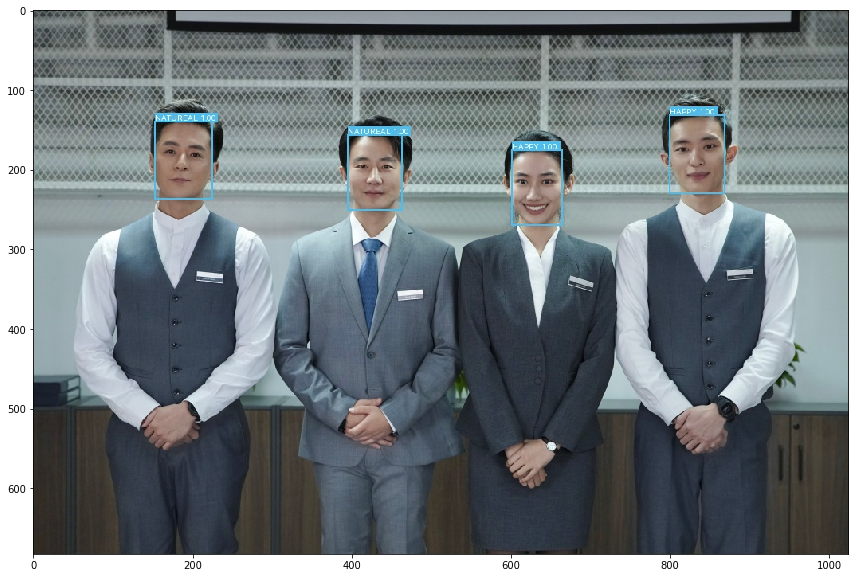

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt 
import cv2

infer_img = cv2.imread("output/test.jpg")
plt.figure(figsize=(15, 10))
plt.imshow(cv2.cvtColor(infer_img, cv2.COLOR_BGR2RGB))
plt.show()

#### 效果展示
**因为fer_2013数据集存在错标的情况，所以正确率没那么高，人眼的正确率就是60%-70%之间,所以目前的精度已经在可以接受的范围内**

![](https://ai-studio-static-online.cdn.bcebos.com/6bbb1c7c896b4443bb81bbd3730e9ba91b5b0dc33d8848ccbd222fcb753bc4c9)


## 九、优化

----------------

### 9.1模型选择

为提升模型训练的效率和获得更高的预测精确度，下面介绍几种常见的优化方法

**模型选择：ResNet34**
不同的神经网络具有不同的结构，深度和参数。针对于本次分类任务，VGG网络不一定是最合适的神经网络，为达到更高的精度，我们可以尝试更换其它神经网络来进行训练。

**ResNet34的介绍**
Kaiming He等人在2015年提出了ResNet，通过引入残差模块加深网络层数，在ImagNet数据集上的错误率降低到3.6%，超越了人眼识别水平。ResNet的设计思想深刻地影响了后来的深度神经网络的设计。

下图表示出了ResNet-34的结构。

![](https://ai-studio-static-online.cdn.bcebos.com/77a40539f644449e965f6d978b1fc78726d961d00c264da4ae4a52794306dcb7)

对比各版本的ResNet模型

![](https://ai-studio-static-online.cdn.bcebos.com/f59c6df80751451f95fce5e3e622390c783d8a34539a48748e628878f5274efd)




* 使用飞桨高层API paddle.vision.models.resnet34() 直接调用图像分类resnet34网络
* ResNet34的实现和训练

In [14]:
model = paddle.vision.models.resnet34(pretrained=True, num_classes = 7) #pretrained：表示是否加载在imagenet数据集上的预训练权重 num_classes由数据集的标签数决定
lr = paddle.optimizer.lr.ReduceOnPlateau(learning_rate=0.0001, factor=0.5, patience=2, verbose=True)
opt = paddle.optimizer.Momentum(learning_rate=lr, momentum=0.9, parameters=model.parameters(), weight_decay=0.001) #选择momentum优化器
# 启动训练过程
train_pm(model, opt,loss_fct,EPOCH_NUM=30, model_name='resnet34')

* ResNet34的评估

In [15]:
use_gpu = True
paddle.set_device('gpu:0') if use_gpu else paddle.set_device('cpu')
model = paddle.vision.models.resnet34(pretrained=True,num_classes = 7) 
params_file_path = './output/resnet34.pdparams'
model_state_dict = paddle.load(params_file_path)
model.load_dict(model_state_dict)
#调用验证
evaluation(model, loss_fct)

start evaluation .......
loss=0.9829, acc=0.6485


* 在使用resnet34进行300epoch训练后，准确率达到64.85%
* 在``./work/``目录下有一个已经训练好的ResNet34权重

### 9.2 学习率的设置

在深度学习神经网络模型中，通常使用标准的随机梯度下降算法更新参数，学习率代表参数更新幅度的大小，即步长。当学习率最优时，模型的有效容量最大，最终能达到的效果最好。学习率和深度学习任务类型有关，合适的学习率往往需要大量的实验和调参经验。探索学习率最优值时需要注意如下两点：

* 学习率不是越小越好。学习率越小，损失函数的变化速度越慢，意味着我们需要花费更长的时间进行收敛，如 图2 左图所示。
* 学习率不是越大越好。只根据总样本集中的一个批次计算梯度，抽样误差会导致计算出的梯度不是全局最优的方向，且存在波动。在接近最优解时，过大的学习率会导致参数在最优解附近震荡，损失难以收敛，如 图2 右图所示。
<center><img src="https://ai-studio-static-online.cdn.bcebos.com/1e0f066dc9fa4e2bbc942447bdc0578c2ffc6afc15684154ae84bcf31b298d7b" width="500" hegiht="" ></center>
<center><br>图2: 不同学习率（步长过大/过小）的示意图</br></center>
<br></br>

## 十、总结与致谢


--------------

* 本项目是PaddleDetection检测人脸+分类模型情绪识别，在这个过程中呢，从无知到认知，学会了很多很多东西，从最开始训练PaddleDetection人脸识别模型到后来VGG情绪识别分类模型，最后将人脸识别的结果输入到情绪识别，并结合返回最后的表情，我学到了很多人工智能、模型训练、图像处理等相关知识，为将来的就业打下基础。同时开始渐渐喜欢上了这个的专业，感受到学习和动手实践的过程才是最完美的。
* 非常感谢孔远杭导师的指导，孔老师在给我们指导答疑过程中认真且有耐心，也教会了我很多之前没有了解到的知识，在这里郑重的感谢孔老师认真负责的指导。
* 也非常感谢百度飞桨能够提供这样的机会和Ai Studio这么方便的平台。

* 关于作者：**河南科技大学软件学院**软件工程专业2019级学生 胡阳 邓小涵 康龙熙 刘召杰 李雪猛

## 十一、待优化地方
* VGG模型的精度有待提高，目前acc=0.6216
* 可以换用ResNet50模型
* 对于一些模糊的人脸应该加以判断，筛除掉那些过于模糊而不能判断情绪的人脸